# Differential evolution optimization

## Import libraries

In [16]:
# Default libraries
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization

# Magic command to automatically reload modules
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [56]:
# List of files for the whole analysis
files = [
    # r"Data\Temple\edf\01_tcp_ar\002\00000254\s007_2013_03_25\00000254_s007_t000.edf",
    # r"Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf",
    # r"Data\Temple\edf\01_tcp_ar\009\00000906\s005_2003_04_27\00000906_s005_t000.edf", # Si
    # r"Data\Temple\edf\01_tcp_ar\009\00000906\s016_2012_03_01\00000906_s016_t000.edf", # Mejor que el pasado
    # r"Data\Temple\edf\01_tcp_ar\012\00001217\s002_2012_09_17\00001217_s002_t000.edf", # Si pero tiene muchos single channel
    # r"Data\Temple\edf\01_tcp_ar\027\00002705\s003_2009_12_04\00002705_s003_t000.edf", # Si
    # r"Data\Temple\edf\01_tcp_ar\045\00004526\s003_2009_09_15\00004526_s003_t001.edf", # Si
    # r"Data\Temple\edf\01_tcp_ar\045\00004526\s006_2010_07_27\00004526_s006_t001.edf", # Si pero es el mismo sujeto que el pasado
    # r"Data\Temple\edf\01_tcp_ar\045\00004586\s002_2009_10_07\00004586_s002_t001.edf", # Si pero es el mismo que el pasado
    r"Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf", # Si

    ]

## General settings

In [32]:
# Settings
artifact_type = "eyem"
window_length = 3   # Window length for artifact [sec]

# Optimization hyperparameters
n_clusters = (1, 10)
fd_threshold = (0.1, 10)
ssa_threshold = (0.001, 0.1)
bounds = (n_clusters, fd_threshold, ssa_threshold)

## Artifact visualization

Enable this next cell to visualize the raw artifacts and make sure you select trials that do not have `variance = 0`.

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\danie\AppData\Local\Temp\ipykernel_23736\4160329296.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  [fig, ax] = plt.subplots()


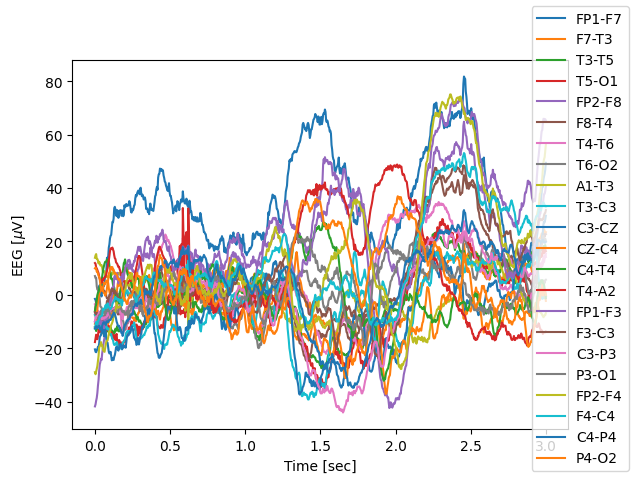

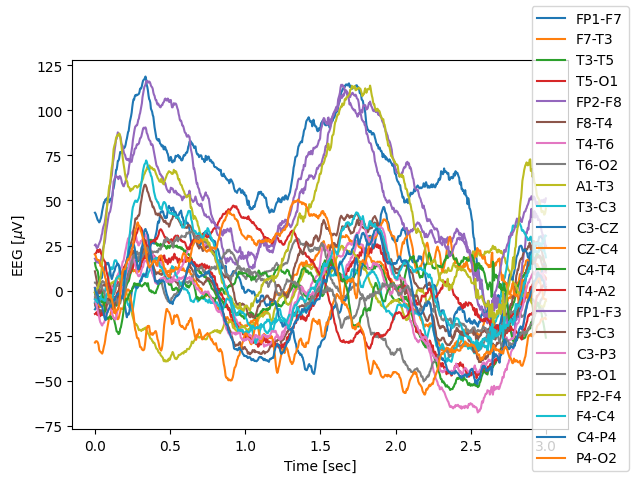

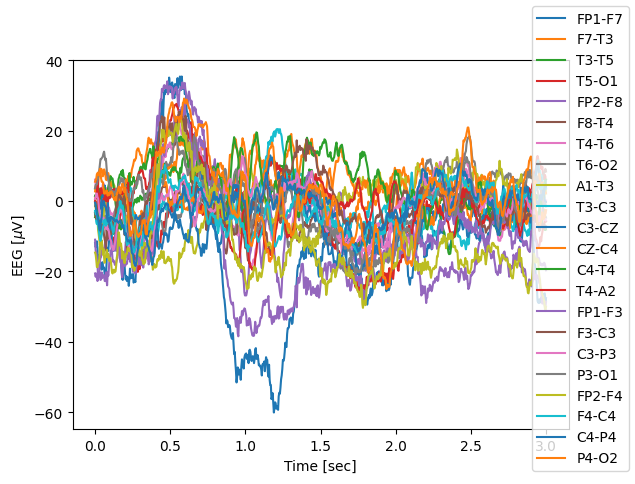

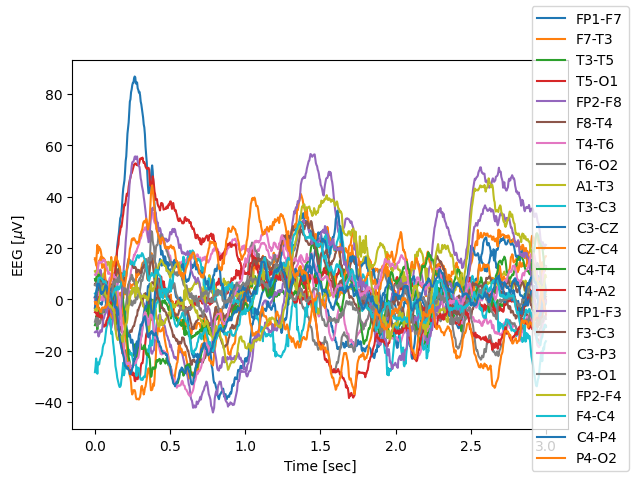

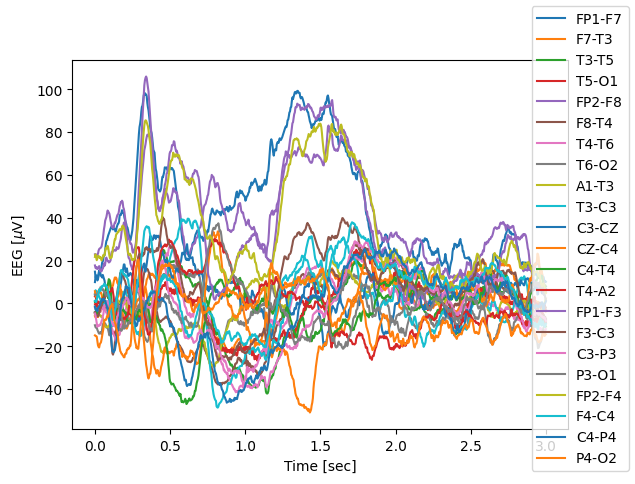

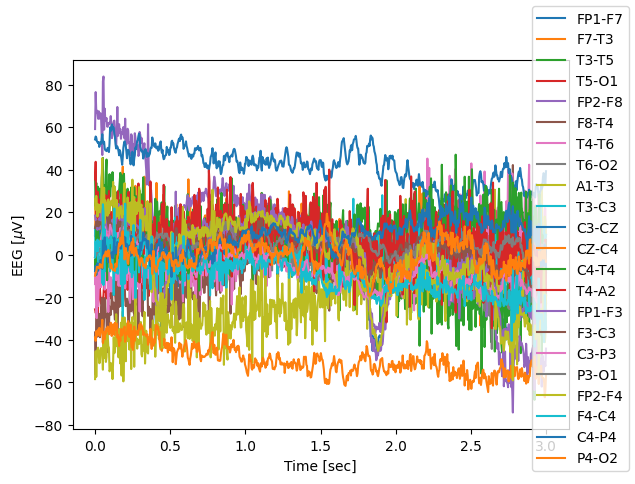

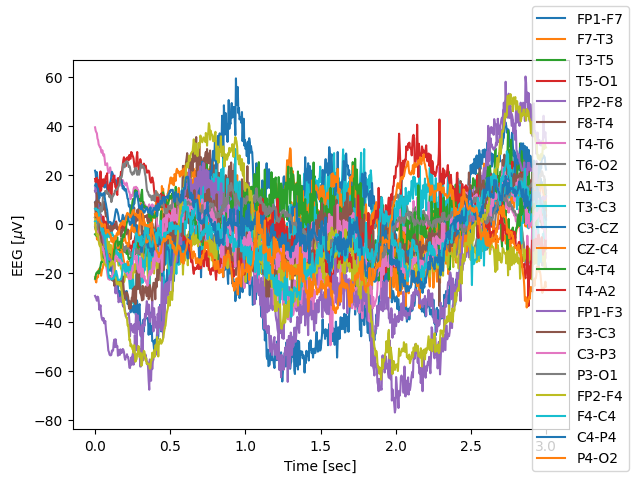

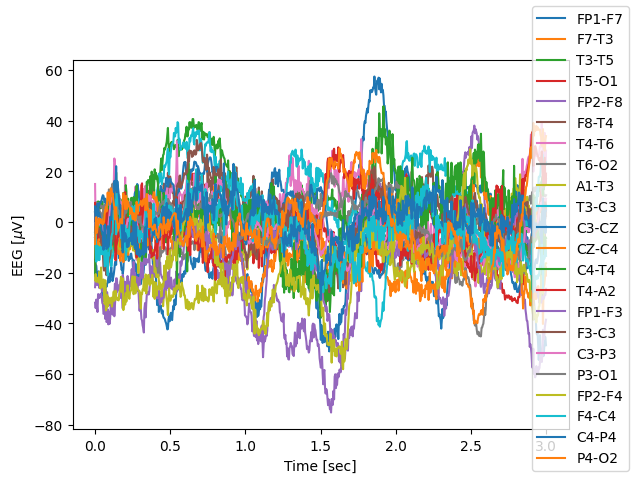

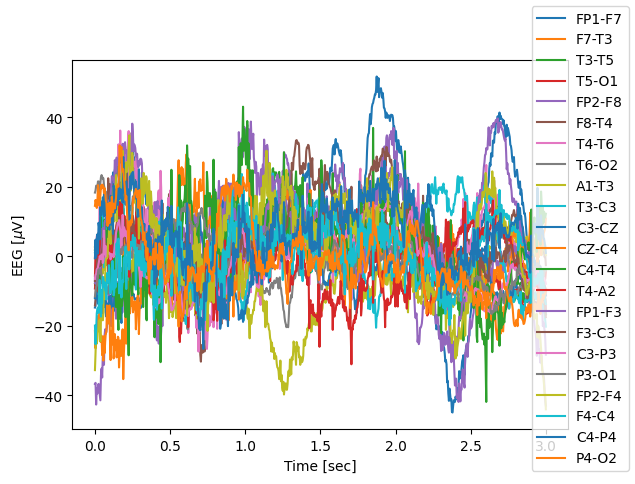

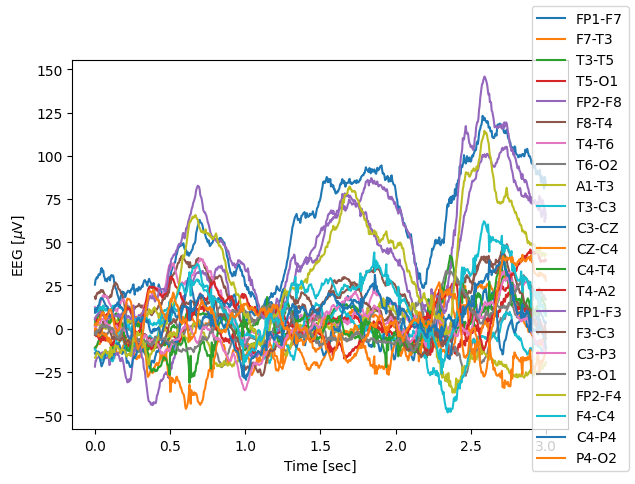

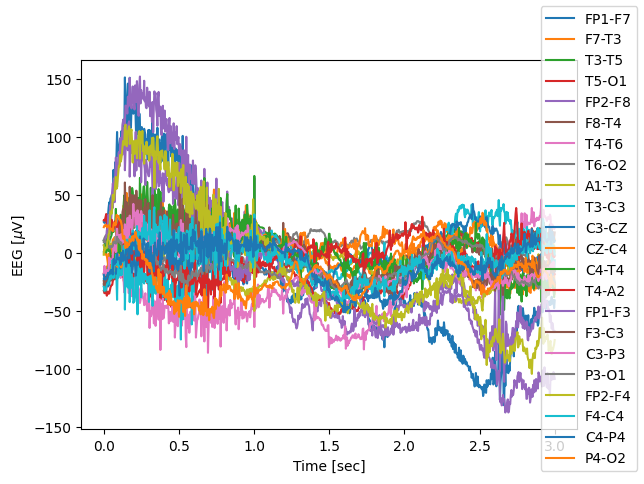

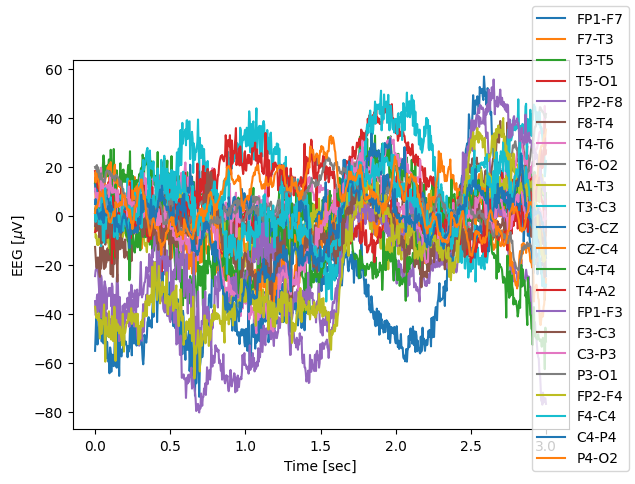

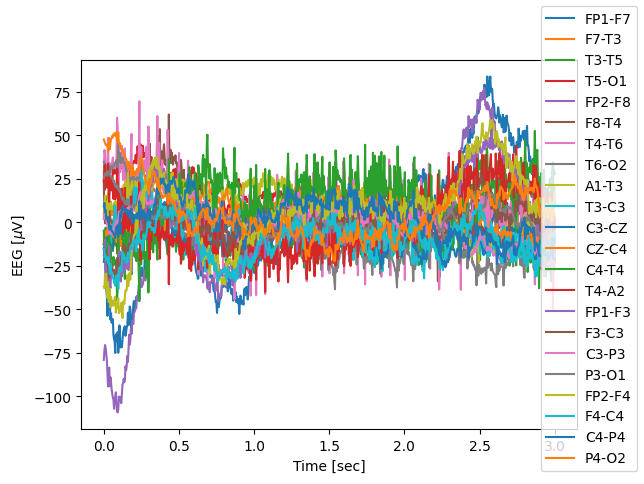

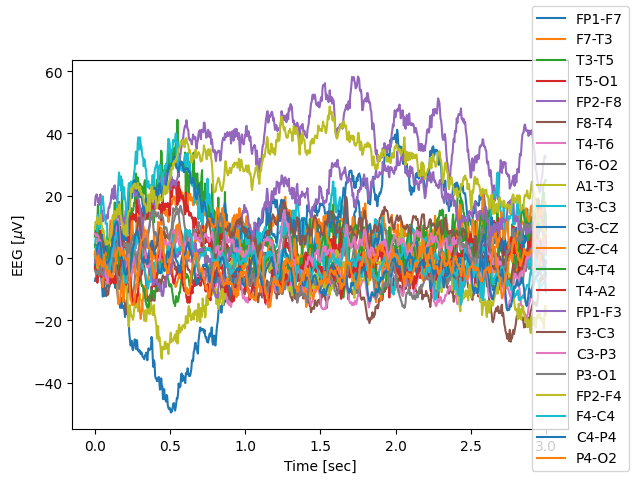

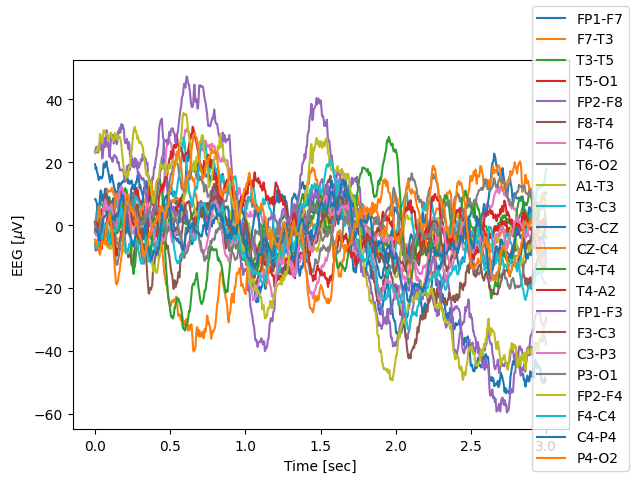

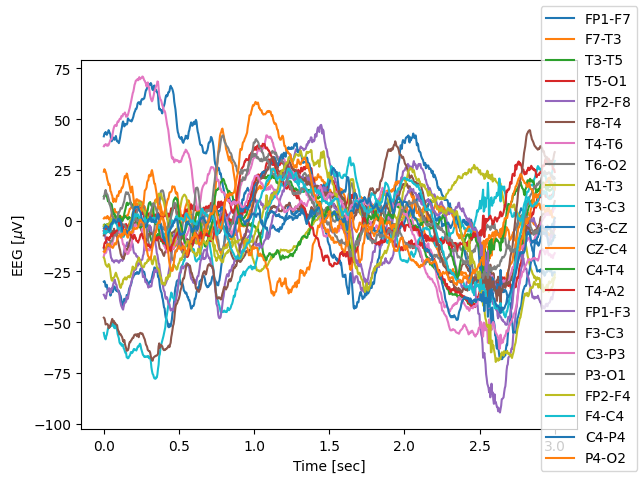

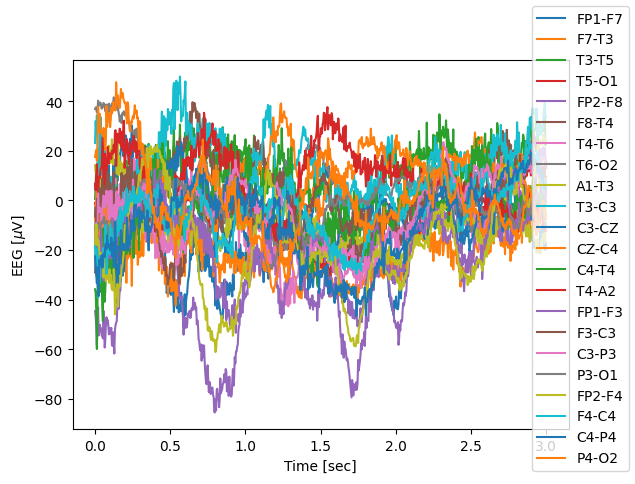

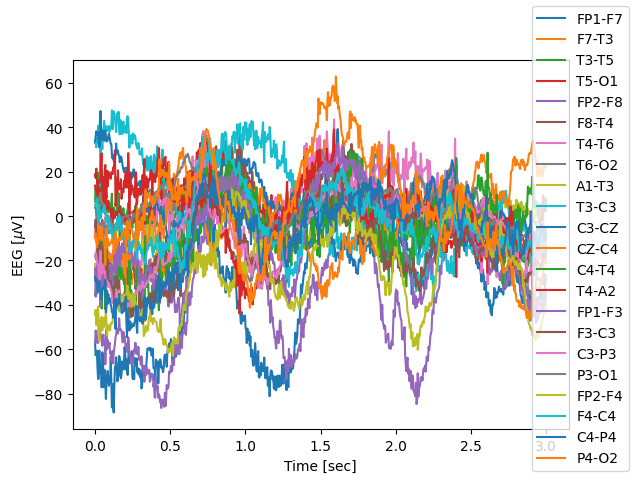

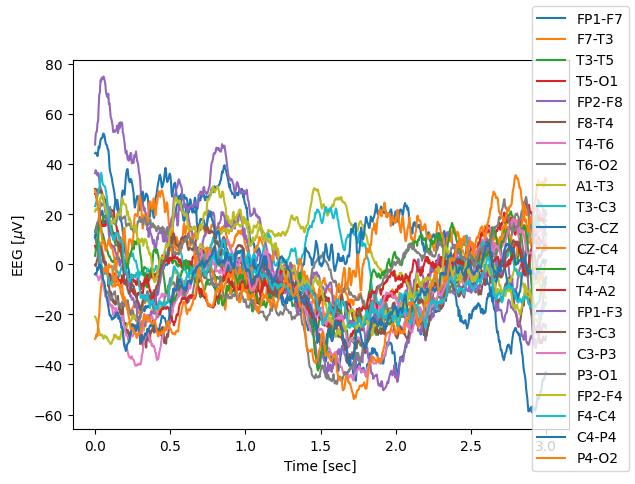

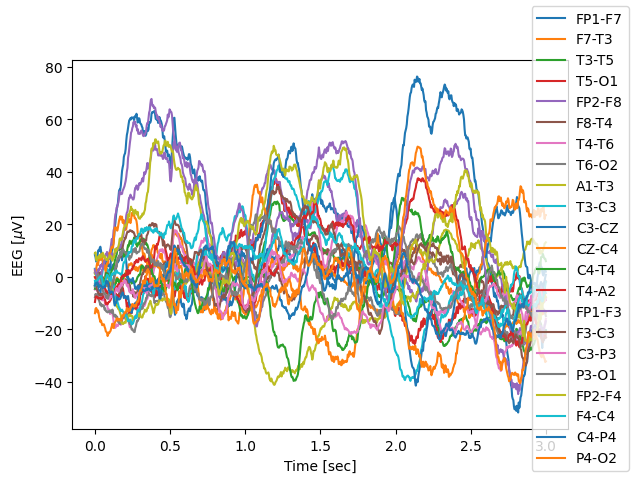

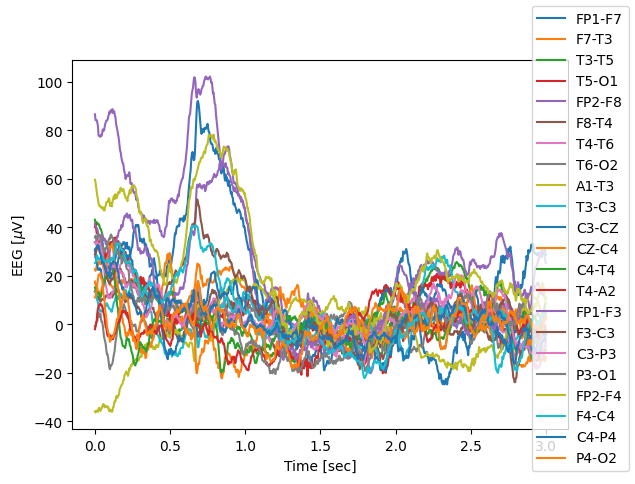

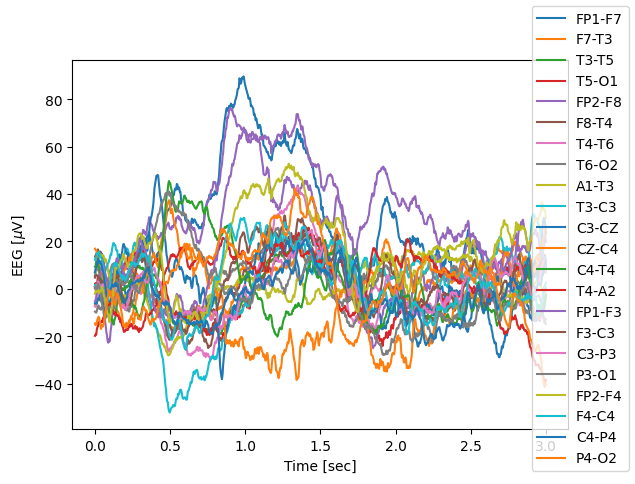

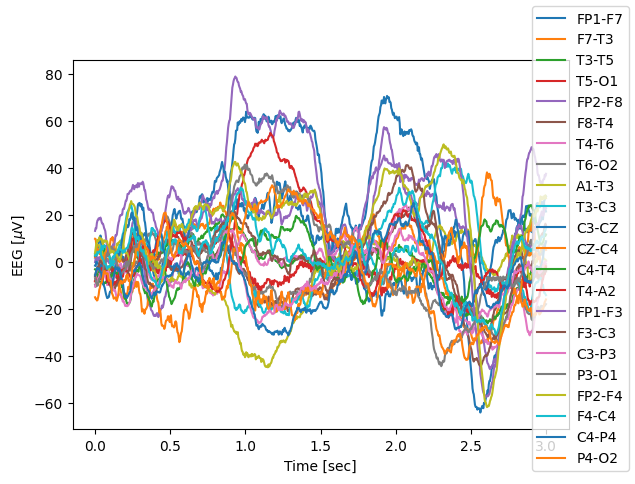

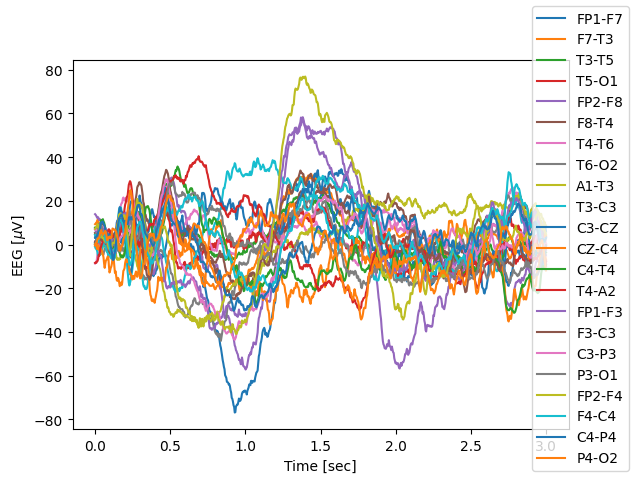

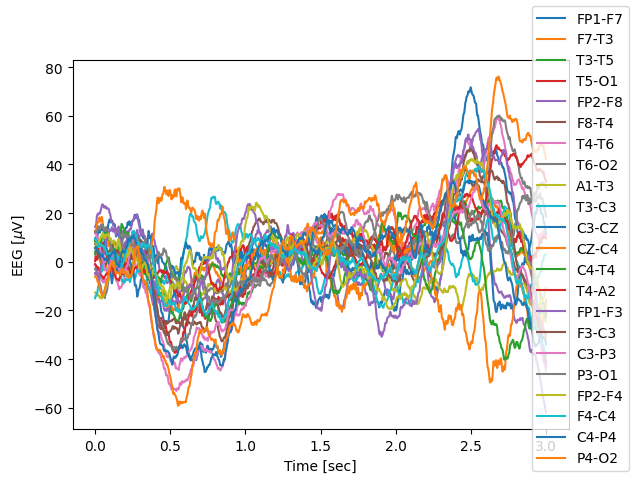

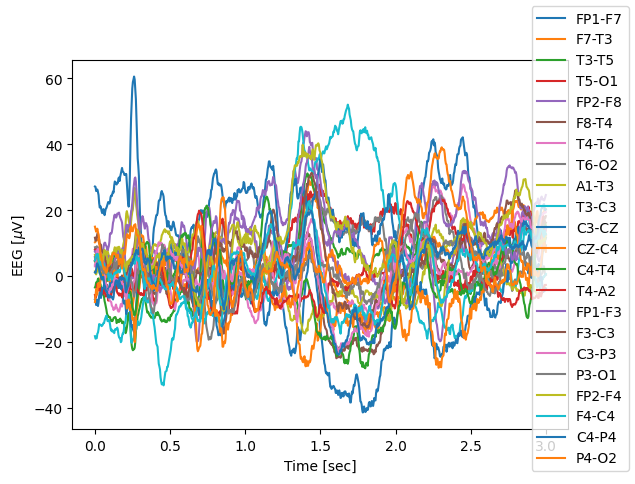

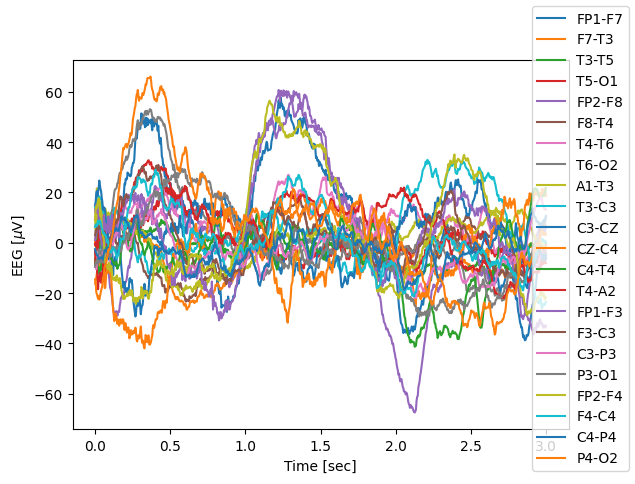

In [57]:
visualize_data = True

if visualize_data:
    for file in files:
        # Import data file
        temple = TempleData(file)
        
        # Get artifact data
        artifact_file = fr'Data\\Temple\\csv\\labels_{temple.montage_type}.csv'
        temple.get_artifacts_from_csv(artifact_file)

        [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
            artifact_type = artifact_type,
            window_length = window_length,
            )
        
        # Get clean data
        clean = temple.get_clean_data(window_length)
        clean_avg = clean[0,:,:]

        # Print artifacts for visualization
        for [a,artifact] in enumerate(artifacts_chans):
            # Create time vector
            nsamples = artifacts_data[a].shape[-1]
            t = np.linspace(0, nsamples/temple.srate, nsamples)

            [fig, ax] = plt.subplots()
            ax.plot(t, 1e6*artifacts_data[a][:,:].T, label=artifact)
            ax.set_xlabel('Time [sec]')
            ax.set_ylabel("EEG [$\mu$V]")
            fig.legend()


## Optimization

In [4]:
for file in files:
    # Import data file
    temple = TempleData(file)

    # Get artifact data
    artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
    temple.get_artifacts_from_csv(artifacts_file)

    [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
        artifact_type = artifact_type,
        window_length = window_length,
        )
    
    # Get clean data
    clean = temple.get_clean_data(window_length)
    clean_avg = clean[10,:,:]

    iteration_results = [None] * len(artifacts_chans)
    temp_results = []
    # Perform optimization per artifact
    for a,artifact in enumerate(artifacts_chans[:-1]):
        
        # iteration_results[a] = []
        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

        # Constant arguments
        args = (
            clean_avg[subset_chans,:],
            artifacts_data[a,:,:], 
            temple.srate,
            window_length
            )
        
        optimization_results = optimize.differential_evolution(
            func = optimization.maximize_eqi,
            bounds = bounds,
            args = args,
            polish = True,
            callback = lambda intermediate_result: temp_results.append(intermediate_result),
            )
        
        iteration_results[a] = temp_results

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 90.47619047619048


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_threshold
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\minicon

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_threshold
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 90.47619047619048


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_threshold
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_threshold
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_thre

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 89.28571428571428
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 85.71428571428571
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 82.14285714285714


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 90.47619047619048


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\artifact_removal_tool.py:289: RuntimeWarning: invalid value encountered in divide
  eigen_ratio = (s / s.sum()) > self.ssa_threshold
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than a

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 86.9047619047619


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476
Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 95.23809523809524


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 88.0952380952381


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = 

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 84.52380952380952


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can av

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 96.42857142857143


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: R

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully
 EQI value 79.76190476190476


c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


## Results

### Iteration results

In [5]:
for iteration in iteration_results:
    nit = iteration["nit"]
    fun = iteration["fun"]
    message = iteration["message"]
    print(f"{message} {nit}: {fun}")

TypeError: list indices must be integers or slices, not str

### Final results

In [10]:
optimization_results

             message: Optimization terminated successfully.
             success: True
                 fun: 79.76190476190476
                   x: [ 7.118e+00  5.640e+00  9.151e-02]
                 nit: 6
                nfev: 319
          population: [[ 7.118e+00  5.640e+00  9.151e-02]
                       [ 9.036e+00  6.914e+00  7.281e-02]
                       ...
                       [ 3.446e+00  6.749e+00  7.622e-02]
                       [ 9.153e+00  8.259e+00  8.965e-02]]
 population_energies: [ 7.976e+01  7.976e+01 ...  7.976e+01  7.976e+01]

### Lowest objective function

Find the iteration that got the lowest objective function for all artifacts

In [12]:
temp_fun = np.inf
ifun = [0,0]

for (a, artifact_iteration) in enumerate(iteration_results):
    for (i,iteration) in enumerate(artifact_iteration):
        
        iteration_fun = iteration["fun"]
        print(f"Artifact {a} - iteration {i}: {iteration_fun}")
        if iteration_fun < temp_fun:
            temp_fun = iteration_fun
            ifun = [a,i]

lowest_iteration = iteration_results[ifun[0]][ifun[1]]



Artifact 0 - iteration 0: 82.14285714285714
Artifact 0 - iteration 1: 82.14285714285714
Artifact 0 - iteration 2: 82.14285714285714
Artifact 0 - iteration 3: 82.14285714285714
Artifact 0 - iteration 4: 82.14285714285714
Artifact 0 - iteration 5: 79.76190476190476
Artifact 0 - iteration 6: 79.76190476190476
Artifact 0 - iteration 7: 79.76190476190476
Artifact 0 - iteration 8: 79.76190476190476
Artifact 0 - iteration 9: 79.76190476190476
Artifact 0 - iteration 10: 79.76190476190476
Artifact 1 - iteration 0: 82.14285714285714
Artifact 1 - iteration 1: 82.14285714285714
Artifact 1 - iteration 2: 82.14285714285714
Artifact 1 - iteration 3: 82.14285714285714
Artifact 1 - iteration 4: 82.14285714285714
Artifact 1 - iteration 5: 79.76190476190476
Artifact 1 - iteration 6: 79.76190476190476
Artifact 1 - iteration 7: 79.76190476190476
Artifact 1 - iteration 8: 79.76190476190476
Artifact 1 - iteration 9: 79.76190476190476
Artifact 1 - iteration 10: 79.76190476190476


In [7]:
lowest_iteration

             message: in progress
             success: True
                 fun: 79.76190476190476
                   x: [ 6.963e+00  3.253e+00  7.969e-02]
                 nit: 1
                nfev: 90
          population: [[ 6.963e+00  3.253e+00  7.969e-02]
                       [ 7.487e+00  3.352e+00  4.418e-02]
                       ...
                       [ 6.736e+00  4.341e+00  1.622e-02]
                       [ 1.206e+00  1.348e+00  3.027e-02]]
 population_energies: [ 7.976e+01  7.976e+01 ...  7.976e+01  7.976e+01]
         convergence: 0.15603684776814677

## Compare test artifact 

In [16]:
itest_artifact = -1
test_artifact_chans = artifacts_chans[itest_artifact]
test_artifact_data = artifacts_data[itest_artifact,:,:]

subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

### RAW EQI

c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: divide by zero encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores
c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Functions\eeg_quality_index.py:83: RuntimeWarning: invalid value encountered in divide
  z_scores = np.floor(np.abs((eqi_test-mean_eqi_clean)/std_eqi_clean)) # Calculate z-scores


Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


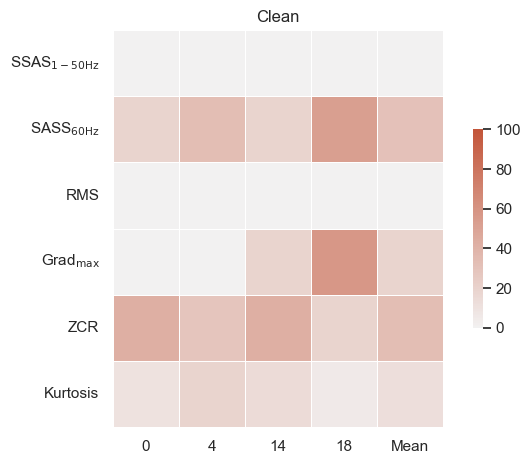

(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'Clean'}>)

In [19]:

raw_eqi = eqi.scoring(
    clean_eeg = clean_avg[subset_chans,:],
    test_eeg = test_artifact_data,
    srate_clean = temple.srate,
    srate_test = temple.srate,
    window = int(temple.srate),
    slide =  int(temple.srate // 10)
)[1]

eqi.heatmap(raw_eqi, subset_chans, title="Clean")

### ART EQI

In [23]:
lowest_iteration["x"]

array([6.96284002, 3.25332277, 0.07968752])

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


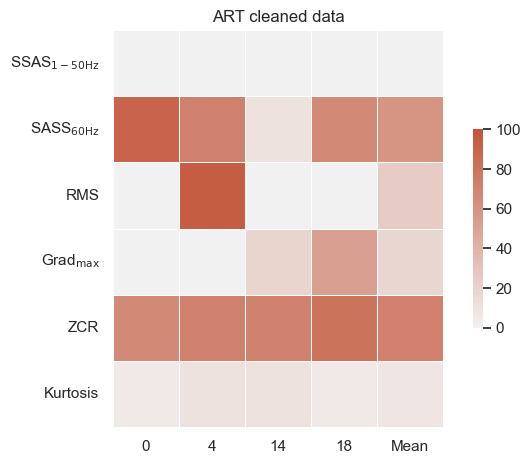

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'ART cleaned data'}>)

In [31]:
art = ART(
    window_length = int(window_length * temple.srate // 2),
    n_clusters = int(lowest_iteration["x"][0]),
    fd_threshold = lowest_iteration["x"][1],
    ssa_threshold = lowest_iteration["x"][2],
)

art_artifact_data = art.remove_artifacts(
    eeg_data = test_artifact_data,
    srate = temple.srate
    )

art_eqi = eqi.scoring(
    clean_eeg = clean_avg[subset_chans, :],
    test_eeg = art_artifact_data,
    srate_clean = temple.srate,
    srate_test = temple.srate,
    window = int(temple.srate),
    slide =  int(temple.srate // 10)
)[1]

eqi.heatmap(art_eqi, subset_chans, title="ART cleaned data")

## DIfference

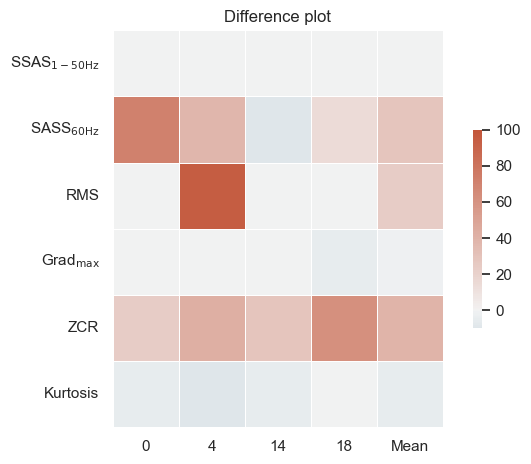

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Difference plot'}>)

In [32]:
eqi.heatmap(
    data = art_eqi - raw_eqi,
    chans = subset_chans,
    title = "Difference plot"
)

## Default vals

c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\danie\miniconda3\envs\art-eqi\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: User

Warning!
One or more Z-scores have NaN values
Review eqi_mean carefully


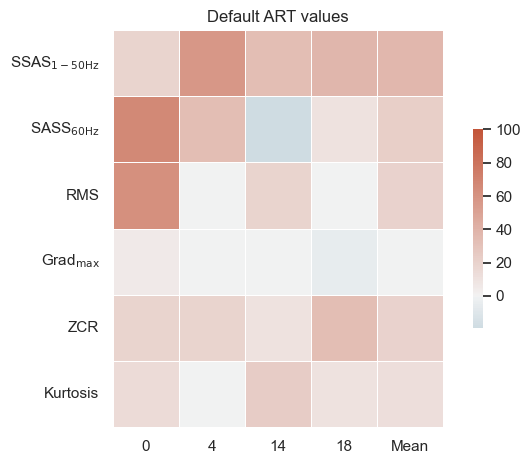

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Default ART values'}>)

In [30]:
art = ART(
    window_length = int(window_length * temple.srate // 2),
)

default_artifact_data = art.remove_artifacts(
    eeg_data = test_artifact_data,
    srate = temple.srate
    )

default_eqi = eqi.scoring(
    clean_eeg = clean_avg[subset_chans, :],
    test_eeg = default_artifact_data,
    srate_clean = temple.srate,
    srate_test = temple.srate,
    window = int(temple.srate),
    slide =  int(temple.srate // 10)
)[1]

eqi.heatmap(
    data = default_eqi - raw_eqi,
    chans = subset_chans,
    title="Default ART values")